In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

In [ ]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

68616192/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [ ]:
# Karena dataset tersebut tidak menyediakan test_dataset maka kita akan ambil 20% data dari validation_dataset untuk keperluan test_dataset. 
# Sisanya yang 80% tetap untuk validation_datase

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
# Gunakan prefetch agar data yang diload sesuai kapasitas memory yang tersedia

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# untuk menambah jumlah data training, digunakan data augmentation

data_augmentation = tf.keras.Sequential([tf.keras.layers.RandomFlip('horizontal'), tf.keras.layers.RandomRotation(0.2),])

In [ ]:
# Loading base model dari pre-trained model MobileNet V2

IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

base_model.trainable = False

14548992/14536120 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
# preprocessing range data input dari [0,255] menjadi [-1,1]
# ada 2 cara, bisa dengan method preprocess_input yang sudah disiapkan mobilenet_V2 atau dengan fungsi rescaling

#preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
preprocess_input = tf.keras.layers.Rescaling(1./127.5, offset=-1)


In [ ]:
# membuat layer Average Pooling

image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)


In [ ]:
# membuat output layer 1 node

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)

In [ ]:
# Ini adalah model baru yang kita definisikan
# Model ini tida mengupdate parameter dari Mobilenet V2. jadi proses training hanya update toplayer (dalam hal ini hanya 1 output layer)

inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
# coba performansi model pada validation_dataset sebelum dilakukan proses training

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 5s 64ms/step - loss: 0.6525 - accuracy: 0.6708


In [ ]:
# Lakukan proses training

initial_epochs = 10
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 11s 95ms/step - loss: 0.6794 - accuracy: 0.6175 - val_loss: 0.4365 - val_accuracy: 0.7488
Epoch 2/10
63/63 [==============================] - 7s 105ms/step - loss: 0.5068 - accuracy: 0.7220 - val_loss: 0.3183 - val_accuracy: 0.8540
Epoch 3/10
63/63 [==============================] - 6s 87ms/step - loss: 0.4027 - accuracy: 0.8030 - val_loss: 0.2594 - val_accuracy: 0.8936
Epoch 4/10
63/63 [==============================] - 6s 89ms/step - loss: 0.3455 - accuracy: 0.8375 - val_loss: 0.2137 - val_accuracy: 0.9171
Epoch 5/10
63/63 [==============================] - 6s 89ms/step - loss: 0.2898 - accuracy: 0.8745 - val_loss: 0.1806 - val_accuracy: 0.9356
Epoch 6/10
63/63 [==============================] - 6s 89ms/step - loss: 0.2777 - accuracy: 0.8810 - val_loss: 0.1602 - val_accuracy: 0.9406
Epoch 7/10
63/63 [==============================] - 6s 88ms/step - loss: 0.2517 - accuracy: 0.8905 - val_loss: 0.1424 - val_accuracy: 0.9468
Epoch 8/10


Berikut ini adalah langkah untuk training juga sebagian dari Mobilenet V2

In [ ]:
base_model.trainable = True

In [ ]:
print("Jumlah layer pada base model: ", len(base_model.layers))

Jumlah layer pada base model:  154


In [ ]:
# jika kita ingin untuk train ulang layer 100 ke atas, 
# sedangkan layer awal sampai layer 100 tidak ditrain ulang

for layer in base_model.layers[:100]:
  layer.trainable = False

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset, epochs=total_epochs, initial_epoch=history.epoch[-1], validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 14s 119ms/step - loss: 0.0566 - accuracy: 0.9795 - val_loss: 0.0401 - val_accuracy: 0.9851
Epoch 11/20
63/63 [==============================] - 7s 106ms/step - loss: 0.0502 - accuracy: 0.9820 - val_loss: 0.0355 - val_accuracy: 0.9889
Epoch 12/20
63/63 [==============================] - 7s 105ms/step - loss: 0.0519 - accuracy: 0.9790 - val_loss: 0.0729 - val_accuracy: 0.9703
Epoch 13/20
63/63 [==============================] - 7s 103ms/step - loss: 0.0520 - accuracy: 0.9805 - val_loss: 0.0499 - val_accuracy: 0.9814
Epoch 14/20
63/63 [==============================] - 7s 104ms/step - loss: 0.0630 - accuracy: 0.9790 - val_loss: 0.0310 - val_accuracy: 0.9876
Epoch 15/20
63/63 [==============================] - 7s 103ms/step - loss: 0.0515 - accuracy: 0.9830 - val_loss: 0.0368 - val_accuracy: 0.9814
Epoch 16/20
63/63 [==============================] - 7s 104ms/step - loss: 0.0569 - accuracy: 0.9780 - val_loss: 0.0579 - val_accuracy: 0.981

In [ ]:
loss, accuracy = model.evaluate(test_dataset)

6/6 [==============================] - 4s 563ms/step - loss: 0.0550 - accuracy: 0.9844




---
# Bagian berikut ini hanya untuk menampilkan data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


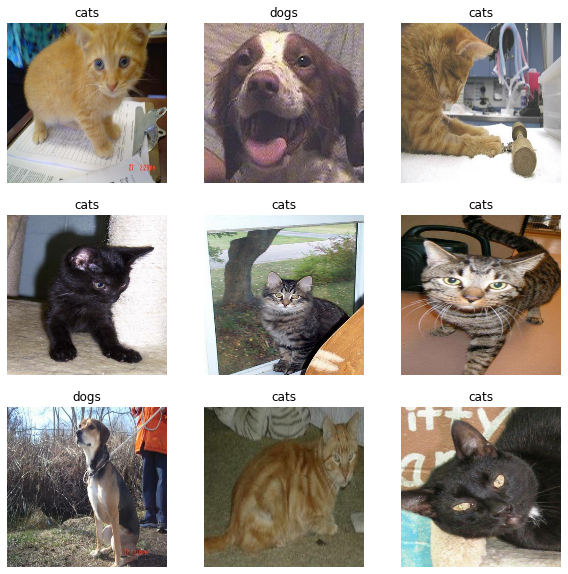

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(3):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

'dogs'

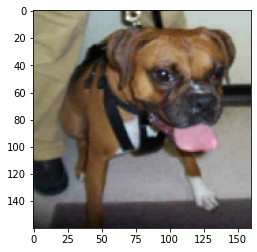

In [ ]:
for images, labels in train_dataset.take(1):  # only take first element of dataset
    images = images.numpy()
    labels = labels.numpy()

plt.imshow(images[0].astype("uint8"))
labels[0]
class_names[labels[0]]

In [ ]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 63
Number of validation batches: 26
Number of test batches: 6


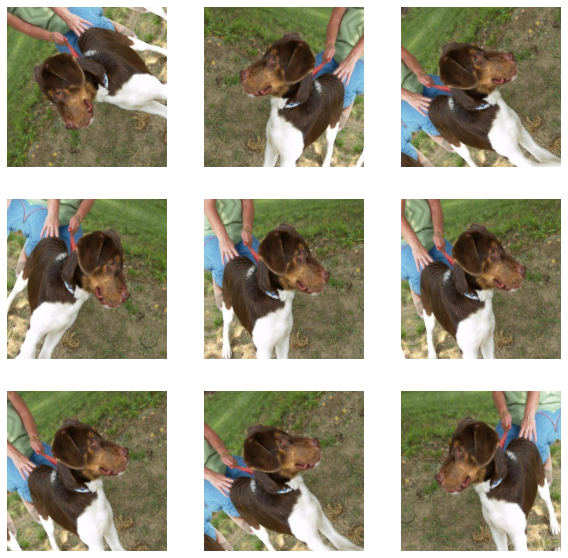

In [ ]:
# bagian ini untuk cetak gambar hasil data augmentation

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')



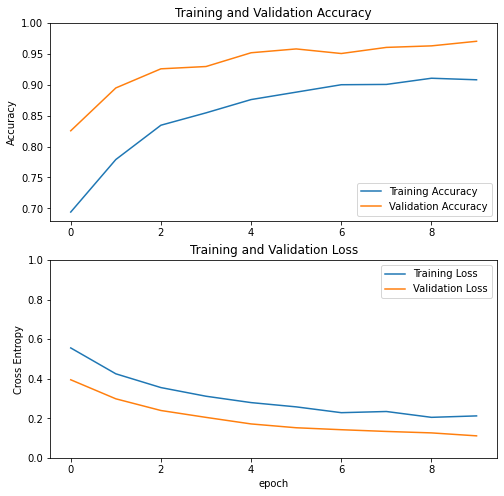

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

FINE TUNING

In [ ]:
len(model.trainable_variables)

56

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

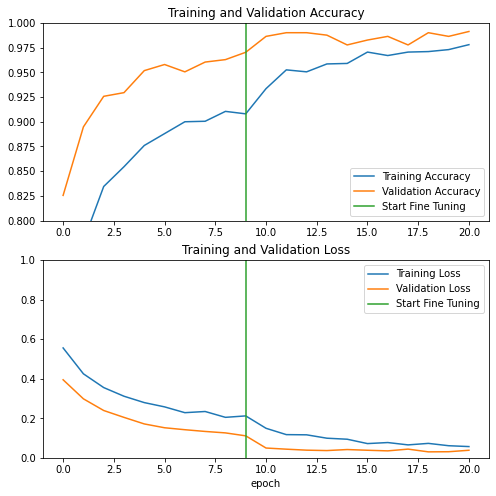

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 4s 529ms/step - loss: 0.0399 - accuracy: 0.9792
Test accuracy : 0.9791666865348816


Predictions:
 [0 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0]
Labels:
 [0 1 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 1 0 0 0 1 1 0]


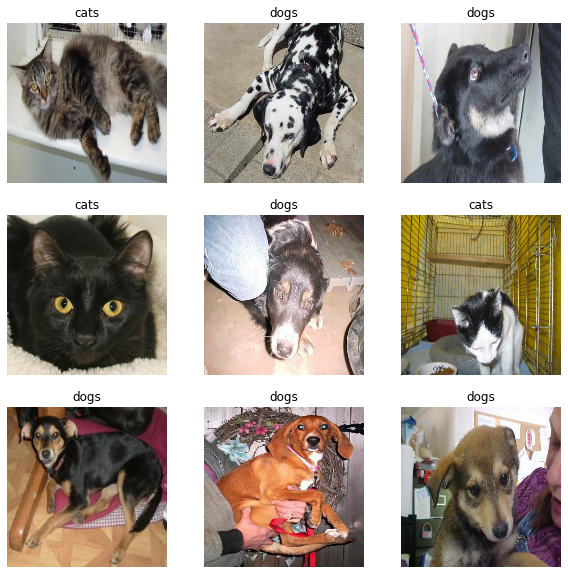

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")